In [26]:
import math
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers


In [27]:
def f_4(x, max = 5):
    x = lambda x: math.sin(math.pi*x) + math.cos(math.pi*x)
    # more than
    if x > 5:
        return math.sin(math.pi*x)
    return x

iterations = 5006

features_functs = [
    lambda x: math.sin(math.pi*x/15),
    lambda x: math.cos(math.pi*x/15),
    lambda x: math.sin(math.pi*x/5),
    lambda x: math.sin(math.pi*x/10),
]

In [28]:
"""
set the relation between features

like there are 4 features, it will be 4 keys in the dict

each key is the index of the feature

the value of each key is a dict, the key of the dict is the index of the feature which is related to the key

the value of the dict is a list, each element of the list is the weight of the relation in the timeseries

f.e. the relation between feature 0 and feature 1 is 0.8 in the last time step

"""
feature_relations = {
    0: {
        1: [0.8, 0.4, 0.2, 1, 0.05, 0.01],
        2: [0.1, 0.05, 0.01, 0.8, 0.4, 0.2],
        3: [2.1, 1.05, 0.01, 0.8, 0.4, 0.2]
    },
    1: {
        0: [1.3, 0.9, 0.8, 0.4, 0.2, 0.1],
        2: [0.65, 0.45, 0.4, 0.2, 0.1, 0.05],
        3: [1.1, 0.8, 0.4, 0.2, 0.1, 0.05]
    },
    2: {
        0: [0.5, 0.4, 0.3, 0.2, 0.1, 0.05],
        1: [0.85, 0.84, 0.83, 0.82, 0.81, 0.805],
        3: [0.9, 0.8, 0.4, 0.2, 0.1, 0.05]
    },
    3: {
        0: [4, 2, 1, 0.5, 0.25, 0.125],
        1: [0.8, 0.4, 0.2, 0.1, 0.05, 0.025],
        2: [1.7, 0.85, 0.425, 0.2125, 0.10625, 0.053125]
    }
}

In [29]:

first_6_values = {x: [features_functs[x](i) for i in range(6)] for x in range(len(features_functs))}

features_values = np.array([first_6_values[x] for x in range(len(features_functs))])
print(features_values)
# fill out 5000 iterations of the timeseries
for i in range(6, iterations):
    new_column_values = []
    for feature in range(len(features_functs)):
        funct = features_functs[feature]
        value_1 = funct(i)
        value_2 = 0

        for relation, array in feature_relations[feature].items():
            value_2 += np.sum(np.array(array) * features_values[relation][i-6:i])

        value_2 = funct(value_2)

        new_column_values.append(value_2*5)
    features_values = np.hstack((features_values,  np.array(new_column_values).reshape(-1, 1)))

print(features_values)

[[0.00000000e+00 2.07911691e-01 4.06736643e-01 5.87785252e-01
  7.43144825e-01 8.66025404e-01]
 [1.00000000e+00 9.78147601e-01 9.13545458e-01 8.09016994e-01
  6.69130606e-01 5.00000000e-01]
 [0.00000000e+00 5.87785252e-01 9.51056516e-01 9.51056516e-01
  5.87785252e-01 1.22464680e-16]
 [0.00000000e+00 3.09016994e-01 5.87785252e-01 8.09016994e-01
  9.51056516e-01 1.00000000e+00]]
[[ 0.          0.20791169  0.40673664 ... -0.70128847  4.92309727
  -4.51231004]
 [ 1.          0.9781476   0.91354546 ... -3.62329117  3.65007668
  -3.54443191]
 [ 0.          0.58778525  0.95105652 ... -3.34790106 -3.77756869
  -0.05369413]
 [ 0.          0.30901699  0.58778525 ...  4.99533038 -2.45605795
   4.99362949]]


(4, 5006)


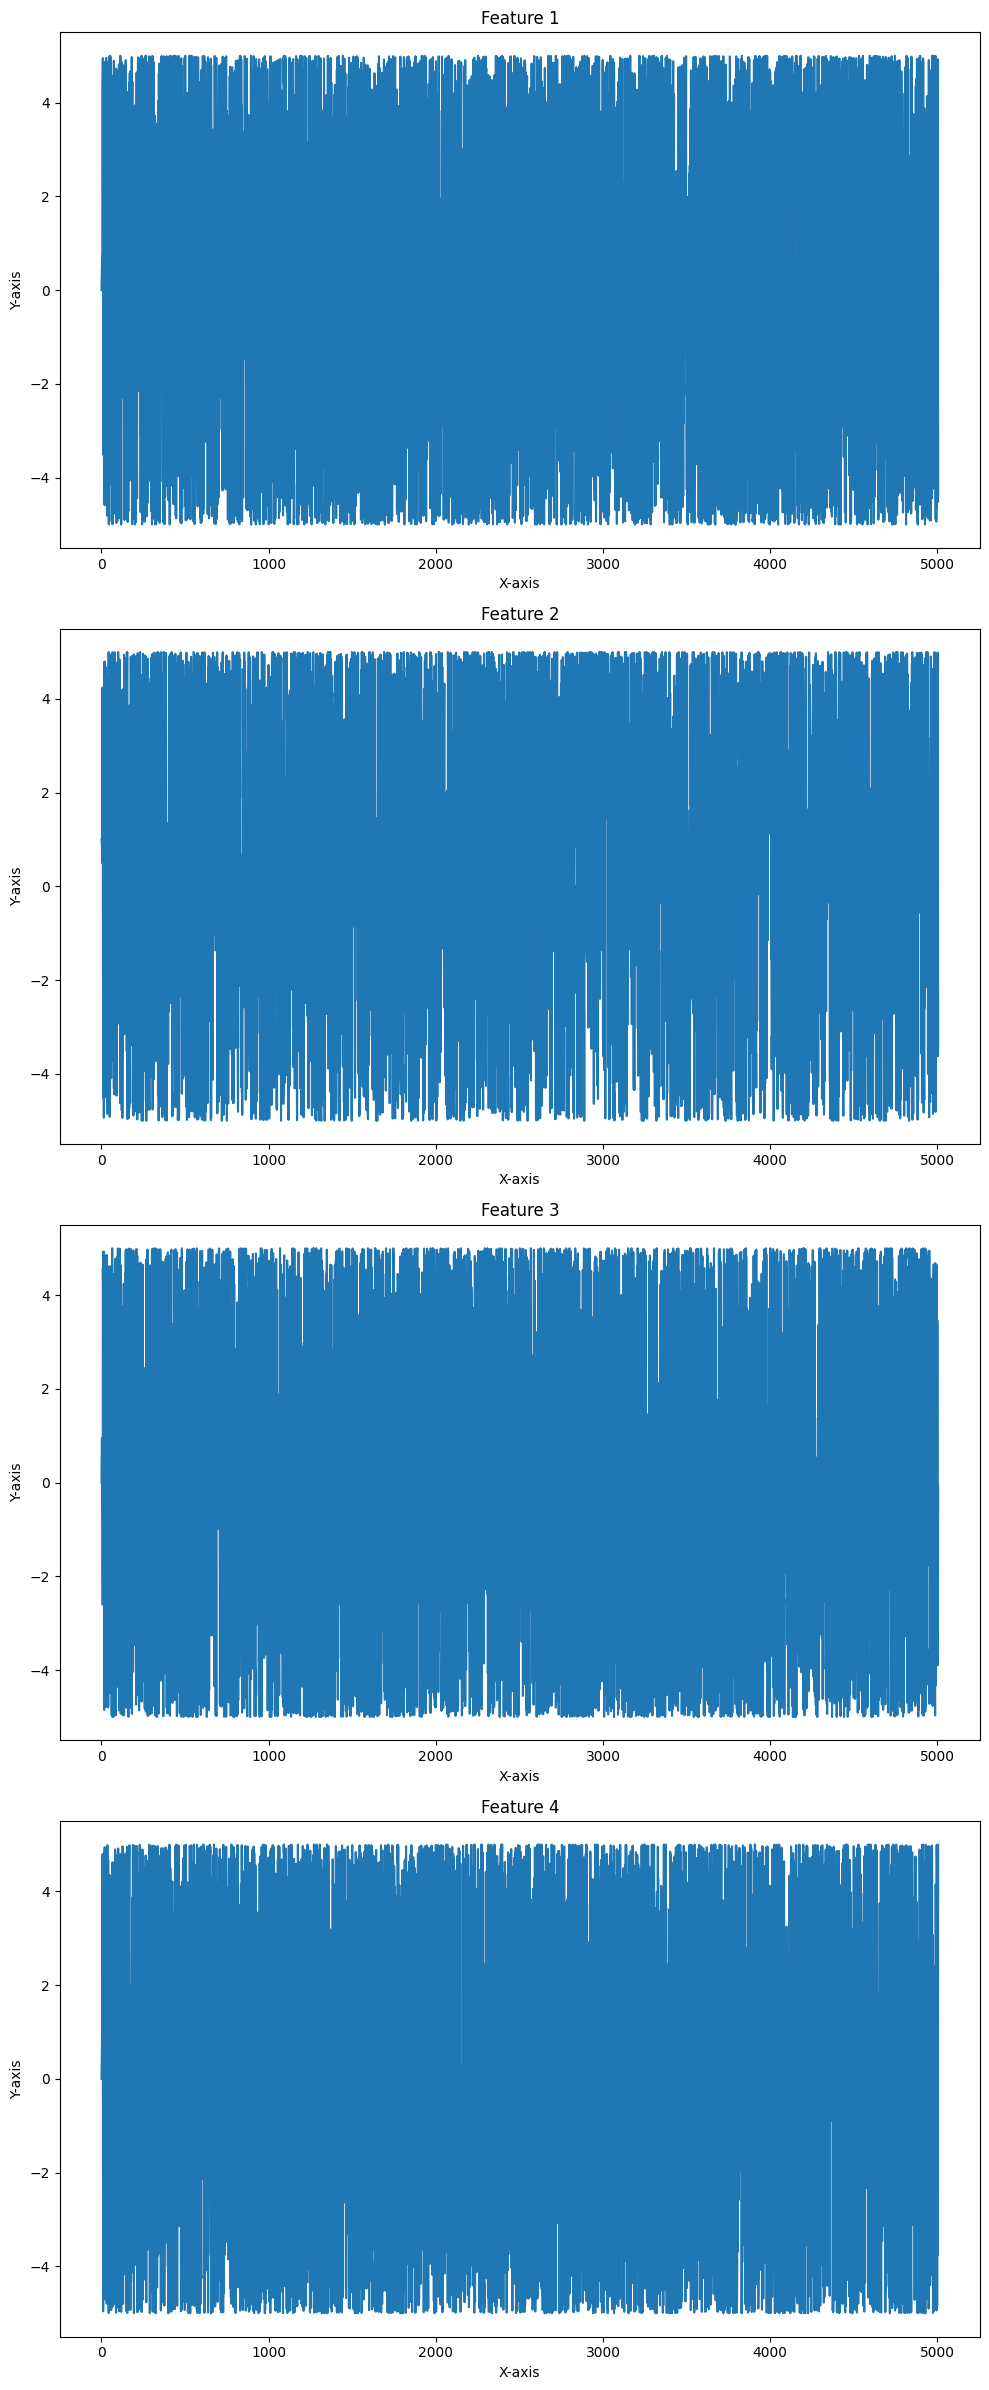

In [30]:
print(features_values.shape)

# Assuming you have your data in a numpy array called 'data' with shape (4, 5006)
# Generate the x-axis values based on the range
x = np.arange(iterations)

# Create subplots for each feature
num_features = 4
fig, axes = plt.subplots(num_features, 1, figsize=(10, 6*num_features))

# Plot each feature
for i in range(num_features):
    axes[i].plot(x, features_values[i])
    axes[i].set_title(f'Feature {i+1}')
    axes[i].set_xlabel('X-axis')
    axes[i].set_ylabel('Y-axis')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


# build train and test data
as input it receives X timeserie steps and predict the next Y steps

In [31]:
t_features_values = features_values.T
t_features_values = t_features_values.reshape((t_features_values.shape[0], t_features_values.shape[1], 1))
"""
i have a ndarray with shape (X, Y, 1) i want a function that receives a separator length that create multiple ndarrays that contains. this shape (separator_length, Y, 1)

f.e.
ndarray = [[[3], [4]], [[1], [2]], [[5], [6]], [[7], [8]], [[9], [10]], [[11], [12]]]
so, shape is (6, 2, 1)
separator_length = 2
the function should return 5 ndarrays with shape (2, 2, 1)
1. [[[3], [4]], [[1], [2]]]
2. [[[1], [2]], [[5], [6]]]
3. [[[5], [6]], [[7], [8]]]
4. [[[7], [8]], [[9], [10]]]
5. [[[9], [10]], [[11], [12]]]
"""
def split_ndarray(ndarray, separator_length):
    if separator_length >= ndarray.shape[0]:
        raise ValueError("separator_length must be smaller than the ndarray's length")
    return np.array([ndarray[i:i+separator_length] for i in range(ndarray.shape[0]-separator_length+1)])

In [33]:
print(t_features_values.shape)

(5006, 4, 1)
